## Configure PySpark Setup

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"


import findspark
findspark.init()


import pyspark 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("App").getOrCreate()
spark

In [2]:
# check number of cores PySpark is using
cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")

You are working with 1 core(s)


In [3]:
!cp /content/drive/MyDrive/Datasets.zip .
!unzip Datasets.zip

Archive:  Datasets.zip
   creating: Datasets/
  inflating: Datasets/fifa19.csv     
  inflating: Datasets/.DS_Store      
  inflating: Datasets/zomato.csv     
  inflating: Datasets/nyc_air_bnb.csv  
  inflating: Datasets/supermarket_sales.csv  
  inflating: Datasets/users3.parquet  
  inflating: Datasets/Toddler Autism dataset July 2018.csv  
   creating: Datasets/uw-madison-courses/
  inflating: Datasets/uw-madison-courses/course_offerings.csv  
  inflating: Datasets/uw-madison-courses/sections.csv  
  inflating: Datasets/uw-madison-courses/schedules.csv  
  inflating: Datasets/uw-madison-courses/database.sqlite3  
  inflating: Datasets/uw-madison-courses/rooms.csv  
  inflating: Datasets/uw-madison-courses/teachings.csv  
  inflating: Datasets/uw-madison-courses/subjects.csv  
  inflating: Datasets/uw-madison-courses/subject_memberships.csv  
  inflating: Datasets/uw-madison-courses/grade_distributions.csv  
  inflating: Datasets/uw-madison-courses/instructors.csv  
  inflating: Dat

# Load Libraries

In [4]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, MinMaxScaler,OneHotEncoder,StandardScaler
from pyspark.sql.types import * 

from pyspark.ml.evaluation import *
from pyspark.sql.functions import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import *

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# ML Model Building

In [5]:
path ="Datasets/"
df = spark.read.csv(path+'housing.csv',inferSchema=True,header=True)

In [6]:
df.limit(6).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY


In [7]:
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [8]:
# Starting
print(df.count())
print(len(df.columns))

20640
10


In [9]:
# missing value count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



In [10]:
# check distinct values in ocean proximity
df.select('ocean_proximity').distinct().collect()


[Row(ocean_proximity='ISLAND'),
 Row(ocean_proximity='NEAR OCEAN'),
 Row(ocean_proximity='NEAR BAY'),
 Row(ocean_proximity='<1H OCEAN'),
 Row(ocean_proximity='INLAND')]

In [11]:
df.groupBy('ocean_proximity').count().show()

+---------------+-----+
|ocean_proximity|count|
+---------------+-----+
|         ISLAND|    5|
|     NEAR OCEAN| 2658|
|       NEAR BAY| 2290|
|      <1H OCEAN| 9136|
|         INLAND| 6551|
+---------------+-----+



In [12]:
#drop missing data
df = df.na.drop()
df.count()

20433

In [13]:
input_columns = ['total_bedrooms','population','households','median_income','ocean_proximity']
dependent_var = 'median_house_value'

In [14]:
renamed = df.withColumnRenamed(dependent_var,'label')
renamed.limit(1).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,label,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY


In [15]:
# train test split
train,test = renamed.randomSplit([0.7,0.3])

In [16]:
# Convert String data type to numeric

numeric_inputs = []
string_inputs = []
labels = {}

for column in input_columns:
    
    if str(train.schema[column].dataType) == 'StringType':
        
        # convert string to numeric
        indexer = StringIndexer(inputCol=column, outputCol=column+"_num") 
        indexer = indexer.fit(train)
        train  =  indexer.transform(train)
        test    =  indexer.transform(test)
        labels[column]=indexer.labels

        # encode numeric string to one hot encoder -default drop lasts category
        encoder = OneHotEncoder(inputCol=column+"_num", outputCol=column+"_enc")
        encoder = encoder.fit(train)
        train = encoder.transform(train)
        test = encoder.transform(test)

        new_col_name = column+"_enc"
        string_inputs.append(new_col_name)
    
    else:
       numeric_inputs.append(column)

In [17]:
indexer.labels

['<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND']

In [18]:
train.limit(3).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,label,ocean_proximity,ocean_proximity_num,ocean_proximity_enc
0,-124.35,40.54,52.0,1820.0,300.0,806.0,270.0,3.0147,94600.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0)"
1,-124.26,40.58,52.0,2217.0,394.0,907.0,369.0,2.3571,111400.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0)"
2,-124.25,40.28,32.0,1430.0,419.0,434.0,187.0,1.9417,76100.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0)"


In [19]:
# treating outlier by caopping quantiles value
d = {}
for col in numeric_inputs: 
    d[col] = train.approxQuantile(col,[0.01,0.99],0.25)
d

{'households': [1.0, 6082.0],
 'median_income': [0.4999, 15.0001],
 'population': [3.0, 28566.0],
 'total_bedrooms': [1.0, 6445.0]}

In [20]:
# treatment for skewness and outlier

for key,data in {'train':train,'test':test}.items():
    for col in numeric_inputs:
        
        # compute skewness    
        skew = data.agg(skewness(data[col])).collect() 
        skew = skew[0][0]

        # treatement for right skew - floor, cap and log(x+1)
        if skew > 1: 
            data = data.withColumn(col,log(when(data[col] < d[col][0],d[col][0]).when(data[col] > d[col][1], d[col][1]).otherwise(data[col] ) +1).alias(col))
            print(f"{key} {col} has been treated for positive (right) skewness. (skew = {skew})")
        
        # treatment for left skew - floor, cap and exp(x)
        elif skew < -1:
            data = data.withColumn(col,exp(when(data[col] < d[col][0],d[col][0]).when(data[col] > d[col][1], d[col][1]).otherwise(data[col] )).alias(col))
            print(f"{key} {col} has been treated for negative (left) skewness. (skew = {skew})")

train total_bedrooms has been treated for positive (right) skewness. (skew = 3.544492940228416)
train population has been treated for positive (right) skewness. (skew = 4.112302137853632)
train households has been treated for positive (right) skewness. (skew = 3.464101870481001)
train median_income has been treated for positive (right) skewness. (skew = 1.677035534536028)
test total_bedrooms has been treated for positive (right) skewness. (skew = 3.2192599605975705)
test population has been treated for positive (right) skewness. (skew = 6.813398633544307)
test households has been treated for positive (right) skewness. (skew = 3.2742719918732437)
test median_income has been treated for positive (right) skewness. (skew = 1.5634480510205504)


In [21]:
features_list = numeric_inputs + string_inputs
features_list

['total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity_enc']

In [22]:
features_names = []
for name in features_list:
    if "_enc" in name:
        x = name.split('_enc')[0]
         # last category is dropped hence not adding to feature names
        for idx in range(0,len(labels[x])-1):
            enc = labels[x][idx]
            value = f"{x}-{enc}"
            features_names.append(value)
    else:
        value = name
        features_names.append(value)
features_names

['total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity-<1H OCEAN',
 'ocean_proximity-INLAND',
 'ocean_proximity-NEAR OCEAN',
 'ocean_proximity-NEAR BAY']

In [23]:
assembler = VectorAssembler(inputCols=features_list,outputCol='features')
train = assembler.transform(train).select('features','label')
train.limit(1).show()

+--------------------+-------+
|            features|  label|
+--------------------+-------+
|[300.0,806.0,270....|94600.0|
+--------------------+-------+



In [24]:
test = assembler.transform(test).select('features','label')
test.limit(1).show()

+--------------------+-------+
|            features|  label|
+--------------------+-------+
|[552.0,1298.0,478...|85800.0|
+--------------------+-------+



In [25]:
## Check for Multicollinearity
pearson_corr = Correlation.corr(train, 'features', 'pearson').collect()[0][0]
pearson_corr = pearson_corr.toArray()

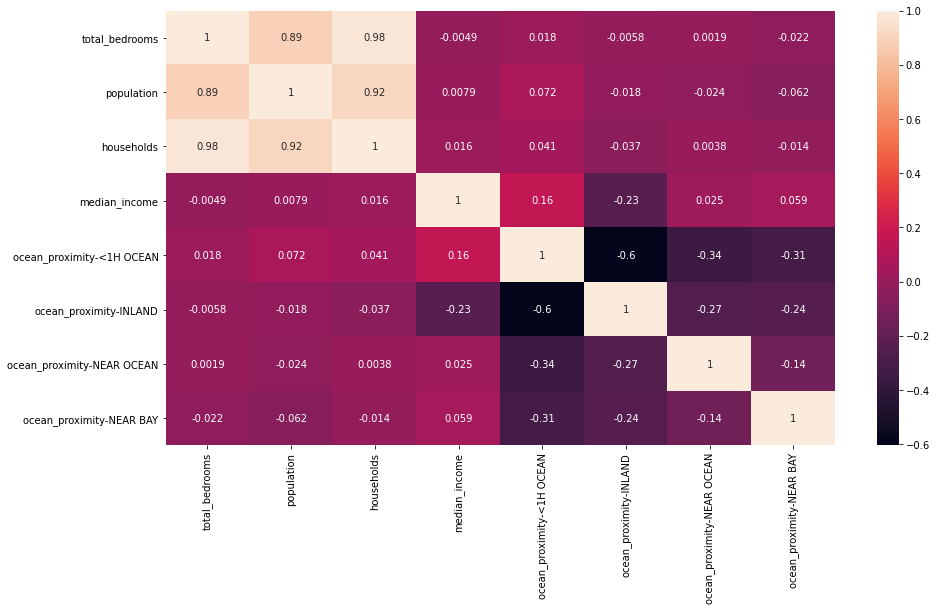

In [26]:
pearson_corr = pd.DataFrame(pearson_corr,columns=features_names,index=features_names)
plt.figure(figsize=(15,8))
sns.heatmap(pearson_corr,annot=True)

In [27]:
# scaling the vectors
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures" )
scaler = scaler.fit(train)

final_train = scaler.transform(train)
final_test = scaler.transform(test)

final_train = final_train.select('label','scaledFeatures').withColumnRenamed("scaledFeatures","features")
final_test = final_test.select('label','scaledFeatures').withColumnRenamed("scaledFeatures","features")

final_train.limit(3).toPandas() 

,label,features
0,94600.0,"[0.7011925425864397, 0.7143705216649039, 0.697..."
1,111400.0,"[0.9208995392635242, 0.8038884158189428, 0.953..."
2,76100.0,"[0.9793322511457274, 0.384661050127256, 0.4831..."


In [28]:
final_test.limit(3).toPandas() 

,label,features
0,85800.0,"[1.290194278359049, 1.1504378872469545, 1.2349..."
1,103600.0,"[1.2411108003779983, 1.1025768349269733, 1.178..."
2,79000.0,"[1.234098874952134, 1.0582610457418056, 1.2013..."


## Linear Regression

In [29]:
# Fit our model
regressor = LinearRegression()
model = regressor.fit(final_train)

In [30]:
# Specify which evaluator you want to use
evaluator = RegressionEvaluator(metricName="rmse")

# Make predictions.
predictions = model.transform(final_test)

# check error
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 72577.1


In [31]:
model.intercept

348654.2885904978

In [32]:
coeff = model.coefficients.toArray().tolist()
coeff.append(model.intercept)
names = features_names + ['Intercept']

pvalue = model.summary.pValues
std_error = model.summary.coefficientStandardErrors

summary = spark.createDataFrame(zip(names,coeff,pvalue,std_error), schema=['feature','coeff','P-Value','Std Error'])
summary.show(truncate=False)

+--------------------------+-------------------+----------------------+------------------+
|feature                   |coeff              |P-Value               |Std Error         |
+--------------------------+-------------------+----------------------+------------------+
|total_bedrooms            |8537.910794776037  |0.0043903196021650714 |2996.681852461185 |
|population                |-52757.09465217344 |0.0                   |1522.6500672527573|
|households                |45092.183923765384 |0.0                   |3471.4533944513655|
|median_income             |70634.69791542056  |0.0                   |611.9815267731851 |
|ocean_proximity-<1H OCEAN |-131323.50691085856|1.2243981739601395E-7 |24813.05455795148 |
|ocean_proximity-INLAND    |-160108.7475168348 |7.002842750125637E-12 |23327.897586138137|
|ocean_proximity-NEAR OCEAN|-84954.47375415722 |4.6553760069123484E-7 |16848.217036794977|
|ocean_proximity-NEAR BAY  |-80585.76751459912 |3.3788812459079054E-7 |15790.558432590655|

In [33]:
# train R2
model.summary.r2

0.6253249953214493

In [34]:
# test R2
test_results = model.evaluate(final_test)
test_results.r2

0.6040574405947692

In [35]:
test_results.rootMeanSquaredError

72577.09778452567

## Decision Tree Regression

In [36]:
# Fit our model
regressor = DecisionTreeRegressor(maxDepth=5)
model = regressor.fit(final_train)

In [37]:
imp_score =model.featureImportances.toArray().tolist()
score = spark.createDataFrame(zip(features_names,imp_score), schema=['feature','imp score'])
score.show(truncate=False)

+--------------------------+--------------------+
|feature                   |imp score           |
+--------------------------+--------------------+
|total_bedrooms            |0.008991400967167027|
|population                |4.70921856079041E-4 |
|households                |5.145307864253963E-4|
|median_income             |0.7442740386805851  |
|ocean_proximity-<1H OCEAN |0.004368157460830069|
|ocean_proximity-INLAND    |0.23570388686772475 |
|ocean_proximity-NEAR OCEAN|0.005677063381188697|
|ocean_proximity-NEAR BAY  |0.0                 |
+--------------------------+--------------------+



In [38]:
predictions = model.transform(final_test)
rmse = evaluator.evaluate(predictions)
rmse

73348.89905017326

## Random Forest

In [39]:
# Fit our model
regressor = RandomForestRegressor(maxDepth=5,numTrees=10)
model = regressor.fit(final_train)

In [40]:
imp_score =model.featureImportances.toArray().tolist()
score = spark.createDataFrame(zip(features_names,imp_score), schema=['feature','imp score'])
score.show(truncate=False)

+--------------------------+--------------------+
|feature                   |imp score           |
+--------------------------+--------------------+
|total_bedrooms            |0.01034008963700518 |
|population                |0.011725300458066832|
|households                |0.010569100952188147|
|median_income             |0.6544485611170623  |
|ocean_proximity-<1H OCEAN |0.04331337678381114 |
|ocean_proximity-INLAND    |0.23040058938238125 |
|ocean_proximity-NEAR OCEAN|0.019842678279412707|
|ocean_proximity-NEAR BAY  |0.019360303390072366|
+--------------------------+--------------------+



In [41]:
predictions = model.transform(final_test)
rmse = evaluator.evaluate(predictions)
rmse

73678.0172582914

## GBT Regressor

In [42]:
# Fit our model
regressor = GBTRegressor(maxDepth=5,maxIter=10,)
model = regressor.fit(final_train)

In [43]:
imp_score =model.featureImportances.toArray().tolist()
score = spark.createDataFrame(zip(features_names,imp_score), schema=['feature','imp score'])
score.show(truncate=False)

+--------------------------+---------------------+
|feature                   |imp score            |
+--------------------------+---------------------+
|total_bedrooms            |0.1707695139414081   |
|population                |0.1833474654855868   |
|households                |0.09416881099596722  |
|median_income             |0.396451813107902    |
|ocean_proximity-<1H OCEAN |0.013521374738159214 |
|ocean_proximity-INLAND    |0.13244597840068809  |
|ocean_proximity-NEAR OCEAN|0.0037890106562697423|
|ocean_proximity-NEAR BAY  |0.005506032674018741 |
+--------------------------+---------------------+



In [44]:
predictions = model.transform(final_test)
rmse = evaluator.evaluate(predictions)
rmse

66970.1272885571

In [45]:
# save model
# this path will create the folder
from datetime import datetime
timestamp = str(datetime.now()) #return local time
path = 'Models/GBT_Model_'+timestamp
model.save(path)